In [1]:
import model
import pandas as pd

In [2]:
scenario = model.CounterterrorismModel(N=200, height=3,width=4,prob_violence=0.0005,policy='NONE',reactive_lvl='none',discontent='mid')
for i in range(700):
    scenario.step()

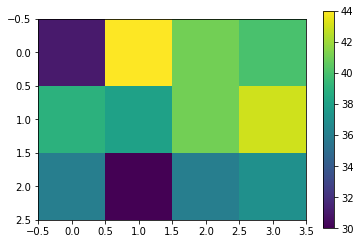

In [3]:
import numpy as np
import matplotlib.pyplot as plt

agent_counts = np.zeros((scenario.grid.width, scenario.grid.height))
for cell in scenario.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count

plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

In [4]:
model_df = scenario.datacollector.get_model_vars_dataframe()
model_df.plot()

<AxesSubplot:>

In [5]:
model_df

num_agents  num_attacks
0           200           44
1           159           47
2           156           47
3           160           47
4           163           47
..          ...          ...
695         463         3895
696         461         3910
697         450         3914
698         455         3920
699         460         3931

[700 rows x 2 columns]

In [24]:
model_df.to_csv('model_df.csv')

In [6]:
agents_df = scenario.datacollector.get_agent_vars_dataframe()
agents_df

status agent_loc
Step AgentID                         
1    1          sympathetic    (2, 0)
     2              neutral    (0, 0)
     3          sympathetic    (0, 1)
     4            combatant    (1, 1)
     5            combatant    (0, 2)
...                     ...       ...
700  4377     anti-violence    (1, 1)
     4378       sympathetic    (1, 3)
     4379     anti-violence    (1, 0)
     4380           neutral    (0, 0)
     4381     anti-violence    (2, 0)

[274876 rows x 2 columns]

In [7]:
agents_df = agents_df.reset_index()
agents_df['step_cat'] = agents_df.Step.astype('str')
agent_stati_gb = agents_df.groupby(by=['step_cat','status'])

In [8]:
agent_stati = agent_stati_gb['AgentID'].nunique().reset_index()
agent_stati = agent_stati.rename(columns={'AgentID':'num_agents'})
agent_stati['step'] = agent_stati.step_cat.astype('int')

palestinian_stati = agent_stati[agent_stati.status.isin(['anti-violence','combatant','neutral','sympathetic'])]
palestinian_stati

step_cat         status  num_agents  step
1           1  anti-violence          47     1
2           1      combatant          46     1
3           1        neutral          55     1
4           1    sympathetic          52     1
6          10  anti-violence          69    10
...       ...            ...         ...   ...
3451       98    sympathetic          78    98
3453       99  anti-violence         207    99
3454       99      combatant           4    99
3455       99        neutral         115    99
3456       99    sympathetic          82    99

[2757 rows x 4 columns]

In [9]:
palestinian_stati.to_csv('palestinian_stati.csv')

<AxesSubplot:xlabel='step', ylabel='num_agents'>

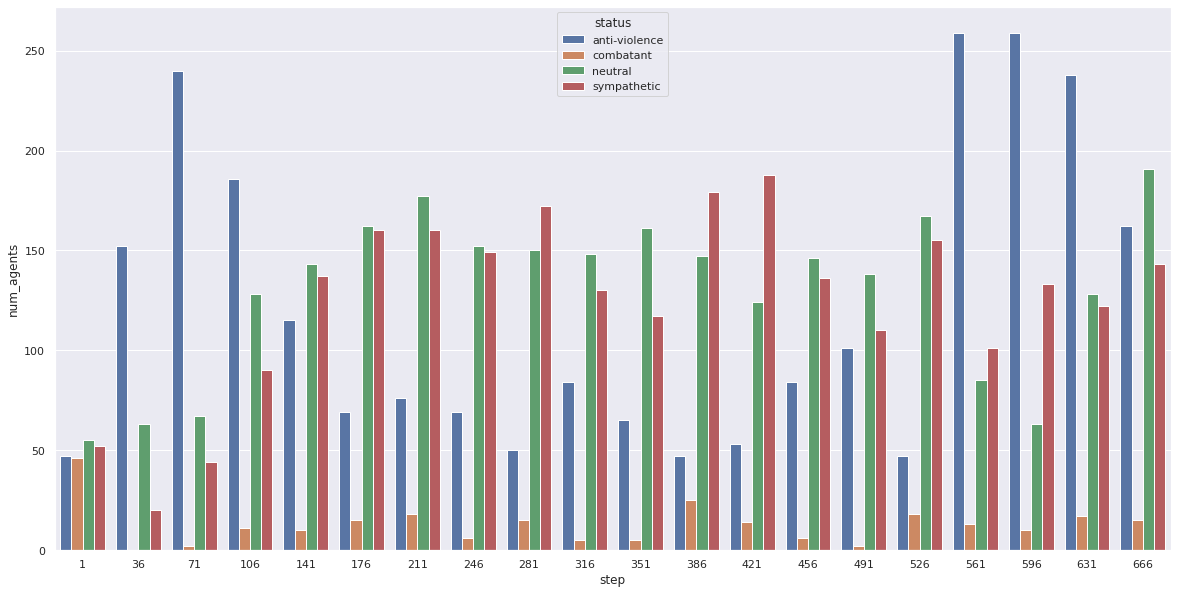

In [10]:
import seaborn as sns
import numpy as np
sns.set(style='darkgrid')
plt.figure(figsize=(20,10))

sns.barplot(x='step',y='num_agents',hue='status',data=palestinian_stati[palestinian_stati.step.isin(range(1,700,round(700*0.05)))])

In [11]:
dominant_sentiments = np.zeros((scenario.grid.width, scenario.grid.height))
dominant_sentiments = dominant_sentiments.astype(str)
dominant_sentiments[dominant_sentiments=='0.0'] = 'none'
percent_dominant_sentiments = np.zeros((scenario.grid.width, scenario.grid.height))

for cell in scenario.grid.coord_iter():
    cell_content, x, y = cell
    status_dict = {'anti-violence':0,'NONE':0,'neutral':0,'sympathetic':0,\
        'combatant':0,'TARG-CONC':0,'TARG-REPR':0,'INDISC-CONC':0,'INDISC-REPR':0}
    for agent in cell_content:
        status_dict[agent.status] += 1

    dominant_sentiment =  max(status_dict, key = lambda x: status_dict[x])
    print(dominant_sentiment)
    if len(cell_content) > 0:
        perc_dominant_sentiment = max(status_dict.values())/len(cell_content)
    else:
        perc_dominant_sentiment = 0

    dominant_sentiments[x][y] = dominant_sentiment 
    percent_dominant_sentiments[x][y] = perc_dominant_sentiment  
     
ax = sns.heatmap(percent_dominant_sentiments, annot=True)
plt.show()

neutral
sympathetic
sympathetic
sympathetic
sympathetic
neutral
sympathetic
sympathetic
sympathetic
sympathetic
sympathetic
anti-violence


In [12]:
dominant_sentiments_df = pd.DataFrame(dominant_sentiments)
dominant_sentiments_df

0            1            2              3
0      neutral  sympathetic  sympathetic    sympathetic
1  sympathetic      neutral  sympathetic    sympathetic
2  sympathetic  sympathetic  sympathetic  anti-violence

In [13]:
# code from stackoverflow
vals_to_int = {j:i for i, j in enumerate(pd.unique(dominant_sentiments.ravel()))}
vals_to_int

{'neutral': 0, 'sympathetic': 1, 'anti-violence': 2}

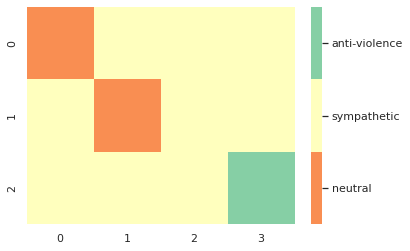

In [14]:
n = len(vals_to_int)
cmap = sns.color_palette('Spectral', n)
ax = sns.heatmap(dominant_sentiments_df.replace(vals_to_int),cmap=cmap)

colorbar = ax.collections[0].colorbar
r = colorbar.vmax - colorbar.vmin
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
colorbar.set_ticklabels(list(vals_to_int.keys()))
plt.show()

In [16]:
govt_status = agent_stati[agent_stati.status.isin(['NONE','INDISC-REPR','INDISC-CONC','TARG-CONC','TARG-REPR'])]
govt_status.drop('num_agents', axis=1,inplace=True)
govt_status = govt_status.sort_values('step',ascending=True)
govt_status

/home/npodpx/venv/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


step_cat       status  step
0           1  INDISC-REPR     1
548         2         NONE     2
1094        3         NONE     3
1641        4         NONE     4
2188        5    TARG-REPR     5
...       ...          ...   ...
3270      696  INDISC-CONC   696
3275      697         NONE   697
3280      698         NONE   698
3285      699         NONE   699
3300      700         NONE   700

[700 rows x 3 columns]

In [30]:
govt_status = agent_stati[agent_stati.status.isin(['NONE','INDISC-REPR','INDISC-CONC','TARG-CONC','TARG-REPR'])]
govt_status.drop('num_agents', axis=1,inplace=True)
govt_status = govt_status.sort_values('step',ascending=True)
govt_status

/home/npodpx/venv/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


step_cat       status  step
0           1  INDISC-CONC     1
541         2    TARG-CONC     2
1087        3         NONE     3
1637        4         NONE     4
2174        5         NONE     5
...       ...          ...   ...
3250      696         NONE   696
3255      697         NONE   697
3260      698    TARG-CONC   698
3265      699         NONE   699
3279      700    TARG-REPR   700

[700 rows x 3 columns]

In [17]:
govt_status_cum = govt_status.groupby(['status']).cumcount()
govt_status_cum = govt_status_cum.rename('cumulative_actions')
govt_status_cum = govt_status.join(govt_status_cum)
govt_status_cum.head(10)

step_cat       status  step  cumulative_actions
0           1  INDISC-REPR     1                   0
548         2         NONE     2                   0
1094        3         NONE     3                   1
1641        4         NONE     4                   2
2188        5    TARG-REPR     5                   0
2735        6         NONE     6                   3
3290        7         NONE     7                   4
3350        8         NONE     8                   5
3404        9         NONE     9                   6
5          10    TARG-CONC    10                   0

In [18]:
plt.figure(figsize=(20,10))

sns.lineplot(x='step',y='cumulative_actions',hue='status',data=govt_status_cum)

<AxesSubplot:xlabel='step', ylabel='cumulative_actions'>

In [19]:
govt_status_cum = pd.get_dummies(govt_status['status']).cumsum()
govt_status_cum

INDISC-CONC  INDISC-REPR  NONE  TARG-CONC  TARG-REPR
0               0            1     0          0          0
548             0            1     1          0          0
1094            0            1     2          0          0
1641            0            1     3          0          0
2188            0            1     3          0          1
...           ...          ...   ...        ...        ...
3270           60           54   431         75         76
3275           60           54   432         75         76
3280           60           54   433         75         76
3285           60           54   434         75         76
3300           60           54   435         75         76

[700 rows x 5 columns]

In [20]:
scenario.datacollector.get_table_dataframe('Deaths')

step  deaths
0       1      44
1       2       3
2       3       0
3       4       0
4       5       0
..    ...     ...
695   696       6
696   697      15
697   698       4
698   699       6
699   700      11

[700 rows x 2 columns]

In [22]:
govt_actions = scenario.datacollector.get_table_dataframe('govt_actions')
govt_actions

step  govt_action action_loc  violence_aftermath
0       1  INDISC-REPR     (0, 0)                  10
1       2         NONE     (0, 0)                  10
2       3         NONE     (0, 0)                   9
3       4         NONE     (0, 0)                   8
4       5    TARG-REPR     (1, 0)                   7
..    ...          ...        ...                 ...
695   696  INDISC-CONC     (0, 0)                  10
696   697         NONE     (0, 0)                  10
697   698         NONE     (0, 0)                  10
698   699         NONE     (0, 0)                  10
699   700         NONE     (0, 0)                  10

[700 rows x 4 columns]

In [23]:
govt_actions.to_csv('govt_actions.csv')